<a href="https://colab.research.google.com/github/tsaravindh/Big_Data_Pipeline/blob/main/Final_Project_Aravindh_Tiruchirapalli_Seetharaman_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ChicagoCrimeDataCleaning").getOrCreate()


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1749560769056_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Reading Data from S3 Bucket

In [ ]:
# S3 Path
s3_path = "s3://chicago-crimes-bucket-aravindh/chicago_crime_report.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(s3_path)


df.show(5)
df.printSchema()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11646166|   JC213529|09/01/2018 12:01:...|082XX S INGLESIDE...|0810|             THEFT|           OVER $500|           RESIDENCE| false|    true| 631|       6|   8|            44|      06| 

Data Cleaning

In [ ]:
from pyspark.sql.functions import col, sum as _sum

df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show(truncate=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|ID |Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward  |Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|0  |4          |0   |0    |0   |0           |0          |10758               |0     |0       |0   |47      |614849|613476        |0       |88111       |88111       |0   |0         |88111   |88111    |88111   |
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

In [ ]:
from pyspark.sql.functions import to_timestamp, hour, dayofweek, month, col

df = df.withColumn("Date_ts", to_timestamp("Date", "MM/dd/yyyy HH:mm:ss a"))

df = df.withColumn("Hour", hour(col("Date_ts"))) \
       .withColumn("DayOfWeek", dayofweek(col("Date_ts"))) \
       .withColumn("Month", month(col("Date_ts")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Keeping the needed columns and removing the unwanted attributes

In [ ]:
# Renaming Community Area to community_area
df = df.withColumnRenamed("Community Area", "community_area")
df = df.withColumnRenamed("Primary Type", "Primary_Type")


df_ml_ready = df.select([
    "Arrest",
    "Domestic",
    "community_area",
    "Primary_Type",
    "Year",
])

# Dropping rows where community_area is NULL
df_ml_ready = df_ml_ready.filter(col("community_area").isNotNull())
df_ml_ready = df_ml_ready.filter(col("Primary_Type").isNotNull())

df_ml_ready.show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+--------------+------------------+----+
|Arrest|Domestic|community_area|      Primary_Type|Year|
+------+--------+--------------+------------------+----+
| false|    true|            44|             THEFT|2018|
| false|   false|            63|DECEPTIVE PRACTICE|2016|
|  true|   false|            41|         NARCOTICS|2018|
| false|   false|            19|   CRIMINAL DAMAGE|2018|
| false|   false|            56|DECEPTIVE PRACTICE|2015|
+------+--------+--------------+------------------+----+
only showing top 5 rows

In [ ]:
#Again checking the NULL values before putting into ATHENA

df_ml_ready.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_ml_ready.columns]).show(truncate=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+--------------+------------+----+
|Arrest|Domestic|community_area|Primary_Type|Year|
+------+--------+--------------+------------+----+
|0     |0       |0             |0           |0   |
+------+--------+--------------+------------+----+

ATHENA TABLE

In [ ]:
import sys

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("boto3")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1749560769056_0001/container_1749560769056_0001_01_000001/tmp/spark-74825be9-f4b8-4eea-947c-daf9221032ac
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.9.4 requires contourpy>=1.0.1, which is not installed.
matplotlib 3.9.4 requires cycler>=0.10, which is not installed.
matplotlib 3.9.4 requires fonttools>=4.22.0, which is not installed.
matplotlib 3.9.4 requires importlib-resources>=3.2.0; python_version < "3.10", which is not installed.
matplotlib 3.9.4 requires kiwisolver>=1.3.1, which is not installed.
matplotlib 3.9.4 requires pillow>=8, 

In [ ]:
import pandas as pd
import boto3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#AWS Configuration

AWS_REGION = "us-east-1"
S3_BUCKET_NAME = "chicago-crimes-bucket-aravindh"
# Athena configuration
DATABASE_NAME = 'default'
TABLE_NAME = 'crime_table'



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
athena_client = boto3.client('athena',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_session_token= ''

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_ml_ready.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Year: integer (nullable = true)

In [ ]:
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {DATABASE_NAME}.{TABLE_NAME} (
    Arrest BOOLEAN,
    Domestic BOOLEAN,
    community_area INT,
    Primary_Type STRING,
    Year INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://{S3_BUCKET_NAME}/athena/'
"""
print(create_table_query.strip())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

CREATE EXTERNAL TABLE IF NOT EXISTS default.crime_table (
    Arrest BOOLEAN,
    Domestic BOOLEAN,
    community_area INT,
    Primary_Type STRING,
    Year INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://chicago-crimes-bucket-aravindh/athena/'

In [ ]:
response = athena_client.start_query_execution(
    QueryString=create_table_query.strip(),
    QueryExecutionContext={'Database': DATABASE_NAME},
    ResultConfiguration={'OutputLocation': f's3://{S3_BUCKET_NAME}/athena-outputs/'}
)

print("Athena table created")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Athena table created

In [ ]:
import time

# Initializing Athena client
# athena_client = boto3.client('athena')

# Function to run Athena query
def run_athena_query(query, database, output_location):
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': output_location
        }
    )
    return response['QueryExecutionId']

# Function to check query status
def check_query_status(query_execution_id):
    while True:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        status = response['QueryExecution']['Status']['State']
        if status == 'SUCCEEDED':
            print("Query succeeded!")
            break
        elif status in ['FAILED', 'CANCELLED']:
            print(f"Query {status.lower()}.")
            raise Exception(f"Query failed or was cancelled: {response}")
        time.sleep(2)


def get_query_results_as_dataframe(query_execution_id):

    results_paginator = athena_client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(QueryExecutionId=query_execution_id)

    columns = []
    rows = []

    for results_page in results_iter:
        # Get column info from the first page
        if not columns:
            columns = [col['Label'] for col in results_page['ResultSet']['ResultSetMetadata']['ColumnInfo']]

        for row in results_page['ResultSet']['Rows'][1:]:
            rows.append([col.get('VarCharValue', None) for col in row['Data']])

    df = pd.DataFrame(rows, columns=columns)
    return df


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
query = f'SELECT * FROM "default"."{TABLE_NAME}" limit 10;'
database = 'default'
output_location = f's3://{S3_BUCKET_NAME}/athena-outputs/'  # Change to your S3 bucket

query_execution_id = run_athena_query(query, database, output_location)

# Checking the status of the query
check_query_status(query_execution_id)

# Fetch the results as a pandas DataFrame
df = get_query_results_as_dataframe(query_execution_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Query succeeded!

Transformed Date into S3 bucket

In [ ]:
df_ml_ready.write.csv("s3://chicago-crimes-bucket-aravindh/athena_cleaned_data/", header=True, mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data Mining and Exploration

In [ ]:
from pyspark.sql.functions import avg, col

print("Crimes per Year:")
df_ml_ready.groupBy("Year").count().orderBy("Year").show()

print("Arrest Rate by Primary_Type:")
df_ml_ready.groupBy("Primary_Type") \
    .agg(avg(col("Arrest").cast("int")).alias("Arrest_Rate")) \
    .orderBy(col("Arrest_Rate").desc()) \
    .show(20, truncate=False)

print("Crimes by community_area:")
df_ml_ready.groupBy("community_area").count() \
    .orderBy(col("count").desc()) \
    .show(20)

print("Top 10 Primary_Type crimes:")
df_ml_ready.groupBy("Primary_Type").count() \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Crimes per Year:
+----+------+
|Year| count|
+----+------+
|2001|  6280|
|2002|354168|
|2003|475935|
|2004|469355|
|2005|453718|
|2006|448129|
|2007|436929|
|2008|426926|
|2009|392606|
|2010|370320|
|2011|351794|
|2012|336247|
|2013|307474|
|2014|275745|
|2015|264775|
|2016|269808|
|2017|269092|
|2018|268811|
|2019|261290|
|2020|212169|
+----+------+
only showing top 20 rows

Arrest Rate by Primary_Type:
+---------------------------------+-------------------+
|Primary_Type                     |Arrest_Rate        |
+---------------------------------+-------------------+
|PROSTITUTION                     |0.9956192816268469 |
|NARCOTICS                        |0.9933199889644809 |
|GAMBLING                         |0.9922945839816255 |
|LIQUOR LAW VIOLATION             |0.9898724391186703 |
|PUBLIC INDECENCY                 |0.9891304347826086 |
|CONCEALED CARRY LICENSE VIOLATION|0.9642537980339589 |
|INTERFERENCE WITH PUBLIC OFFICER |0.9220945083014048 |
|OBSCENITY                      

MLib

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Encoding Primary Type

In [ ]:
# StringIndexer for Primary_Type
primary_type_indexer = StringIndexer(inputCol="Primary_Type", outputCol="Primary_Type_index")

df_ml_ready_indexed = primary_type_indexer.fit(df_ml_ready).transform(df_ml_ready)

df_ml_ready_indexed.select("Primary_Type", "Primary_Type_index").show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+
|      Primary_Type|Primary_Type_index|
+------------------+------------------+
|             THEFT|               0.0|
|DECEPTIVE PRACTICE|               8.0|
|         NARCOTICS|               3.0|
|   CRIMINAL DAMAGE|               2.0|
|DECEPTIVE PRACTICE|               8.0|
+------------------+------------------+
only showing top 5 rows

Combining all the feature columns into one column using Vector Assembler

In [ ]:
assembler = VectorAssembler(
    inputCols=["Domestic", "community_area", "Year", "Primary_Type_index"],  # NOTE: these are in "quotes"
    outputCol="features"
)

df_final = assembler.transform(df_ml_ready_indexed)

df_final.select("features", "Arrest").show(5, truncate=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+------+
|features             |Arrest|
+---------------------+------+
|[1.0,44.0,2018.0,0.0]|false |
|[0.0,63.0,2016.0,8.0]|false |
|[0.0,41.0,2018.0,3.0]|true  |
|[0.0,19.0,2018.0,2.0]|false |
|[0.0,56.0,2015.0,8.0]|false |
+---------------------+------+
only showing top 5 rows

In [ ]:
from pyspark.sql.functions import col

# Cast Arrest to int
df_final = df_final.withColumn("Arrest_int", col("Arrest").cast("int"))

# running StringIndexer on Arrest_int
arrest_indexer = StringIndexer(inputCol="Arrest_int", outputCol="label")
df_final_indexed = arrest_indexer.fit(df_final).transform(df_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_final_indexed.select("Arrest", "Arrest_int", "label").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----------+-----+
|Arrest|Arrest_int|label|
+------+----------+-----+
| false|         0|  0.0|
| false|         0|  0.0|
|  true|         1|  1.0|
| false|         0|  0.0|
| false|         0|  0.0|
+------+----------+-----+
only showing top 5 rows

* Arrest -> true -> 1
* Arrest -> False ->0

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression

In [ ]:
# Splitting data into train/test
train_data, test_data = df_final_indexed.randomSplit([0.8, 0.2], seed=42)

#Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)

predictions.select("features", "Arrest", "prediction", "probability").show(5, truncate=False)

# Evaluating model
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.4f}")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+----------+----------------------------------------+
|features            |Arrest|prediction|probability                             |
+--------------------+------+----------+----------------------------------------+
|[0.0,0.0,2005.0,1.0]|false |0.0       |[0.7322425797573185,0.26775742024268145]|
|[0.0,0.0,2003.0,8.0]|false |0.0       |[0.588638868560601,0.411361131439399]   |
|[0.0,0.0,2010.0,8.0]|false |0.0       |[0.6619857724006845,0.33801422759931554]|
|(4,[2],[2008.0])    |false |0.0       |[0.772105903437215,0.22789409656278503] |
|[0.0,1.0,2002.0,4.0]|false |0.0       |[0.6531104666820509,0.34688953331794914]|
+--------------------+------+----------+----------------------------------------+
only showing top 5 rows

Test AUC: 0.6212

I used Logistic Regression to predict the probability of arrest, and evaluated the model using AUC(Area Under Curve). The AUC of 0.62 indicates that the model can capture some patterns.

Decision Tree Classifier:

In [ ]:
# Initializing the Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5, maxBins=50)

dt_model = dt.fit(train_data)

dt_predictions = dt_model.transform(test_data)

dt_predictions.select("features", "Arrest", "prediction", "probability").show(5, truncate=False)

# Evaluating d model
dt_evaluator = BinaryClassificationEvaluator(labelCol="label")
dt_auc = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree Test AUC: {dt_auc:.4f}")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+----------+----------------------------------------+
|features            |Arrest|prediction|probability                             |
+--------------------+------+----------+----------------------------------------+
|[0.0,0.0,2005.0,1.0]|false |0.0       |[0.8408258999964462,0.15917410000355378]|
|[0.0,0.0,2003.0,8.0]|false |0.0       |[0.9095011282434888,0.0904988717565112] |
|[0.0,0.0,2010.0,8.0]|false |0.0       |[0.9095011282434888,0.0904988717565112] |
|(4,[2],[2008.0])    |false |0.0       |[0.8408258999964462,0.15917410000355378]|
|[0.0,1.0,2002.0,4.0]|false |0.0       |[0.8070414102370896,0.19295858976291042]|
+--------------------+------+----------+----------------------------------------+
only showing top 5 rows

Decision Tree Test AUC: 0.6092

As we can see from the above AUC, The decision tree is just 60.92 % and its little low when compared to Logistic regression prediction.

In [ ]:
sc.install_pypi_package("matplotlib")




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sc.install_pypi_package("python-dateutil==2.8.2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

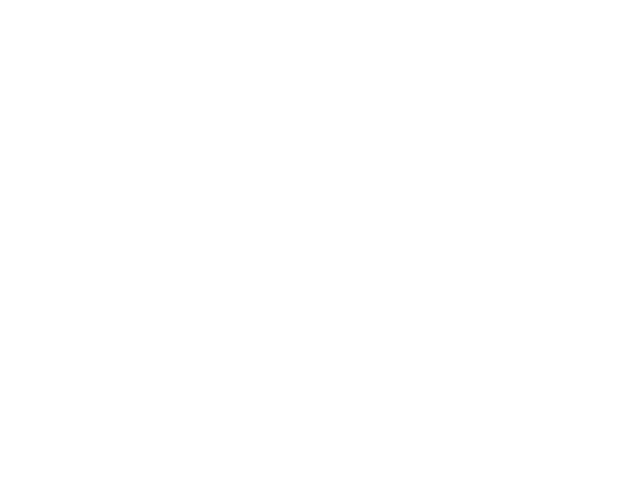

In [ ]:
import matplotlib.pyplot as plt
%matplot plt



In [ ]:
df_arrest_rate = df_ml_ready.groupBy("Primary_Type") \
    .agg(avg(col("Arrest").cast("int")).alias("Arrest_Rate")) \
    .orderBy(col("Arrest_Rate").desc()) \
    .limit(10) \
    .toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import boto3
import io
from pyspark.sql.functions import col, avg, count, desc

# Setting up matplotlib for EMR
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# AWS S3 Configuration
S3_BUCKET = "chicago-crimes-bucket-aravindh"
S3_PLOTS_PREFIX = "plots/"

def save_plot_to_s3(plt, filename, bucket=S3_BUCKET):
    """Save matplotlib plot to S3 bucket"""
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png', dpi=300, bbox_inches='tight')
    img_data.seek(0)

    s3_client = boto3.client('s3')
    s3_client.put_object(
        Body=img_data,
        Bucket=bucket,
        Key=f"{S3_PLOTS_PREFIX}{filename}",
        ContentType='image/png'
    )
    print(f"Plot saved to s3://{bucket}/{S3_PLOTS_PREFIX}{filename}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Visualization of CRIME TRENDS OVER TIME
# crimes per year data
crimes_per_year = df_ml_ready.groupBy("Year").count().orderBy("Year").toPandas()

plt.figure(figsize=(12, 6))
plt.plot(crimes_per_year['Year'], crimes_per_year['count'], marker='o', linewidth=2, markersize=6)
plt.title('Chicago Crime Trends Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

max_crimes_year = crimes_per_year.loc[crimes_per_year['count'].idxmax()]
plt.annotate(f'Peak: {max_crimes_year["count"]:,} crimes\nin {max_crimes_year["Year"]}',
             xy=(max_crimes_year['Year'], max_crimes_year['count']),
             xytext=(max_crimes_year['Year']+2, max_crimes_year['count']+20000),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, ha='center')

plt.tight_layout()
%matplot plt
save_plot_to_s3(plt, "crime_trends_over_time.png")
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot saved to s3://chicago-crimes-bucket-aravindh/plots/crime_trends_over_time.png

In [ ]:
#  ARREST RATES BY CRIME TYPE


# Get arrest rates for top 15 crime types
arrest_rates = df_ml_ready.groupBy("Primary_Type") \
    .agg(avg(col("Arrest").cast("int")).alias("Arrest_Rate"),
         count("*").alias("Total_Crimes")) \
    .filter(col("Total_Crimes") > 10000) \
    .orderBy(col("Arrest_Rate").desc()).limit(15).toPandas()

plt.figure(figsize=(14, 8))
colors = plt.cm.RdYlBu_r(arrest_rates['Arrest_Rate'])
bars = plt.bar(range(len(arrest_rates)), arrest_rates['Arrest_Rate'], color=colors)

plt.xticks(range(len(arrest_rates)), arrest_rates['Primary_Type'], rotation=45, ha='right')
plt.ylabel('Arrest Rate', fontsize=12)
plt.title('Arrest Rates by Crime Type (Min 10K Cases)', fontsize=16, fontweight='bold')
plt.ylim(0, 1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
%matplot plt
save_plot_to_s3(plt, "arrest_rates_by_crime_type.png")
plt.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot saved to s3://chicago-crimes-bucket-aravindh/plots/arrest_rates_by_crime_type.png

In [ ]:
# ML MODEL PERFORMANCE COMPARISON of DECISION TREE AND LOGISTIC REGRESSION


# Model performance data (from your previous results)
models = ['Logistic Regression', 'Decision Tree']
auc_scores = [0.6212, 0.6092]  # Your actual AUC scores

plt.figure(figsize=(10, 6))
bars = plt.bar(models, auc_scores, color=['skyblue', 'lightcoral'], alpha=0.8)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Model Performance Comparison (AUC Scores)', fontsize=16, fontweight='bold')
plt.ylim(0, 1)

for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Performance')
plt.legend()

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
%matplot plt
save_plot_to_s3(plt, "model_performance_comparison.png")
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot saved to s3://chicago-crimes-bucket-aravindh/plots/model_performance_comparison.png